## Loading the data

We will use the [Coronavirus tweets NLP - Text Classification](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!cp '/content/drive/MyDrive/Colab Notebooks/NLP1C/BERT/Corona_NLP_train.csv' .
!cp '/content/drive/MyDrive/Colab Notebooks/NLP1C/BERT/Corona_NLP_test.csv' .

In [6]:
import pandas as pd
import numpy as np

In [7]:
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin')

In [8]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [10]:
mapping = {'Neutral': 0,
           'Positive': 1,
           'Negative': 2,
           'Extremely Positive': 3,
           'Extremely Negative': 4}

In [11]:
train_df['Sentiment'] = train_df['Sentiment'].map(mapping)
test_df['Sentiment'] = test_df['Sentiment'].map(mapping)

In [12]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",4


In [13]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,4
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,1
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,3
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,2
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,0


In [14]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.9+ MB
None


In [15]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 178.2+ KB
None


## Exploring data

Let's have a look at the lengths of comments from the dataset to know, whether there are entries with the length greater than 512 tokens after tokenizing the comment.

In [ ]:
!pip install transformers

In [17]:
from transformers import BertTokenizer, BertModel

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
token_lengths = []
for i in range(len(train_df)):
    text = train_df.iloc[i]['OriginalTweet']
    tokens = tokenizer.tokenize(text)
    token_lengths.append(len(tokens))

In [20]:
print('Max length of tokenized comment: {}'.format(np.max(token_lengths)))
print('Min length of tokenized comment: {}'.format(np.min(token_lengths)))
print('Median length of tokenized comment: {}'.format(np.median(token_lengths)))

Max length of tokenized comment: 246
Min length of tokenized comment: 1
Median length of tokenized comment: 53.0


We see that the maximum length is 246, so we don't have to worry about exceeding the maximum possible sequence length for BERT, which is 512. Anyway, let's have a look at tokenized comments length ditribution.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

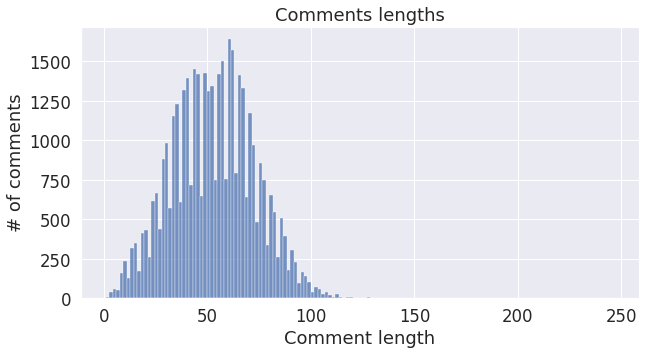

In [22]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10, 5)

sns.histplot(token_lengths)
plt.title('Comments lengths')
plt.xlabel('Comment length')
plt.ylabel('# of comments')
plt.show()

In [23]:
token_lengths_test = []
for i in range(len(test_df)):
    text = test_df.iloc[i]['OriginalTweet']
    tokens = tokenizer.tokenize(text)
    token_lengths_test.append(len(tokens))

In [24]:
print('Max length of tokenized comment: {}'.format(np.max(token_lengths_test)))
print('Min length of tokenized comment: {}'.format(np.min(token_lengths_test)))
print('Median length of tokenized comment: {}'.format(np.median(token_lengths_test)))

Max length of tokenized comment: 141
Min length of tokenized comment: 6
Median length of tokenized comment: 57.0


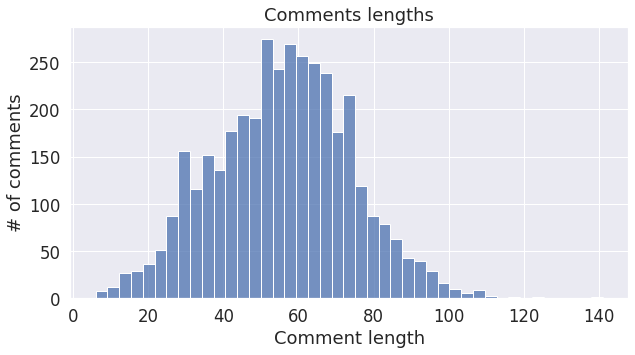

In [25]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10, 5)

sns.histplot(token_lengths_test)
plt.title('Comments lengths')
plt.xlabel('Comment length')
plt.ylabel('# of comments')
plt.show()

## Preparing data to the BERT model

In [26]:
import torch
import torch.nn as nn

In [27]:
train_tweets = train_df.OriginalTweet.values
train_labels = train_df.Sentiment.values
test_tweets = test_df.OriginalTweet.values
test_labels = test_df.Sentiment.values

In [28]:
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

In [29]:
input_ids = []
token_type_ids = []
attention_masks = []

for tweet in train_tweets:

    encoded_dict = tokenizer.encode_plus(text=tweet,
                                         add_special_tokens=True,
                                         max_length=128,
                                         padding='max_length',
                                         truncation=True,
                                         return_attention_mask=True,
                                         return_token_type_ids=True,
                                         return_tensors='pt')
    
    input_ids.append(encoded_dict['input_ids'])
    token_type_ids.append(encoded_dict['token_type_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [37]:
print('Tweet text: ', train_tweets[0])
print('Token IDs:', input_ids[0])
print('Token type ids: ', token_type_ids[0])
print('Attention mask: ', attention_masks[0])

Tweet text:  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
Token IDs: tensor([  101,  1030,  2273, 12541, 11283,  1030,  6316,  1035, 11721,  4819,
         1030,  3782,  4183,  2615, 16770,  1024,  1013,  1013,  1056,  1012,
         2522,  1013,  2065,  2480,  2683, 15143,  2475,  4502,  1998, 16770,
         1024,  1013,  1013,  1056,  1012,  2522,  1013, 22038,  2575,  5603,
        25708,  2480,  9468,  1998, 16770,  1024,  1013,  1013,  1056,  1012,
         2522,  1013,  1045,  2475, 20554, 26494,  2595,  3630,  2620,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [32]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, random_split

In [33]:
BATCH_SIZE = 64
dataset = TensorDataset(input_ids, token_type_ids, attention_masks, train_labels)

dataloader = DataLoader(dataset,
                        sampler=RandomSampler(dataset),
                        batch_size=BATCH_SIZE)

## Using BertModel from hugginface to get tweet embeddings

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.to(device)

Let's use the approach of concatenating the last four layer's hidden states and then averaging token embeddings of non padding tokens of the tweet to get the tweet embedding.

In [50]:
%%time
model.eval()
sentence_embeddings = []
sentence_labels = []

for i, batch in enumerate(dataloader):
    batch_input_ids = batch[0].to(device)
    batch_token_type_ids = batch[1].to(device)
    batch_attention_mask = batch[2].to(device)
    batch_labels = batch[3].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, 
                        token_type_ids=batch_token_type_ids,
                        attention_mask=batch_attention_mask)
        hidden_states = outputs[2]
        pooled_output = torch.cat(tuple([hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        batch_attention_mask = batch_attention_mask.unsqueeze(-1).expand(pooled_output.shape)
        pooled_output = torch.mul(pooled_output, batch_attention_mask)
        pooled_output = torch.sum(pooled_output, dim=1) / torch.sum(batch_attention_mask, dim=1)

    sentence_embeddings.append(pooled_output)
    sentence_labels.append(batch_labels)

sentence_embeddings = torch.cat(sentence_embeddings, dim=0)
sentence_labels = torch.cat(sentence_labels, dim=0)

CPU times: user 2min 54s, sys: 2min 18s, total: 5min 12s
Wall time: 5min 12s


In [52]:
sentence_dataset = TensorDataset(sentence_embeddings, sentence_labels)

## Training a classifier

Let's use some classifier which uses generated tweet's embeddings.

In [132]:
train_size = int(0.8 * len(sentence_dataset))
val_size = len(sentence_dataset) - train_size

train_dataset, val_dataset = random_split(sentence_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

32,925 training samples
8,232 validation samples


In [133]:
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, 
                          sampler=RandomSampler(train_dataset),
                          batch_size=BATCH_SIZE)

val_loader = DataLoader(val_dataset,
                        sampler=RandomSampler(val_dataset),
                        batch_size=BATCH_SIZE)

In [ ]:
num_classes = 5

classifier = nn.Sequential(
    # nn.Dropout(p=0.2),
    nn.Linear(in_features=sentence_embeddings.shape[1], out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=num_classes)
)
classifier.to(device)

In [135]:
import time
from IPython.display import clear_output

In [136]:
def train(model, device, iterator, optimizer, criterion, train_loss_history=None,
          valid_loss_history=None, train_acc_history=None, valid_acc_history=None,
          plot_local=True):
    model.train()
    epoch_loss = 0
    train_acc = 0
    history = []

    for i, (batch, labels) in enumerate(iterator):
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(batch)

        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        # Calculate train accuracy
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:

            if plot_local:
                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

                clear_output(True)
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Train loss')
                if train_loss_history is not None:
                    ax[1].plot(train_loss_history, label='train loss history')
                    ax[1].set_xlabel('Epoch')
                    ax[2].plot(train_acc_history, label='train accuracy history')
                    ax[2].set_xlabel('Epoch')
                if valid_loss_history is not None:
                    ax[1].plot(valid_loss_history, label='valid loss history')
                    ax[2].plot(valid_acc_history, label='valid accuracy history')
                plt.legend()

                plt.show()

    return epoch_loss / len(iterator), train_acc / len(iterator)


def evaluate(model, device, iterator, criterion):
    model.eval()
    epoch_loss = 0
    valid_acc = 0

    with torch.no_grad():
        for i, (batch, labels) in enumerate(iterator):
            batch, labels = batch.to(device), labels.to(device)

            output = model(batch)
            loss = criterion(output, labels)

            epoch_loss += loss.item()

            # Calculate validation accuracy
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item()

    return epoch_loss / len(iterator), valid_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train_model(model, device, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, model_name="model.pth"):
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    best_valid_loss = float('inf')

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion,
                                      train_loss_history, valid_loss_history, 
                                      train_acc_history, valid_acc_history,
                                      plot_local=True)
        
        valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)

        lr_scheduler.step()

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)

        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')

In [137]:
n_epochs = 20
opt = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.2)

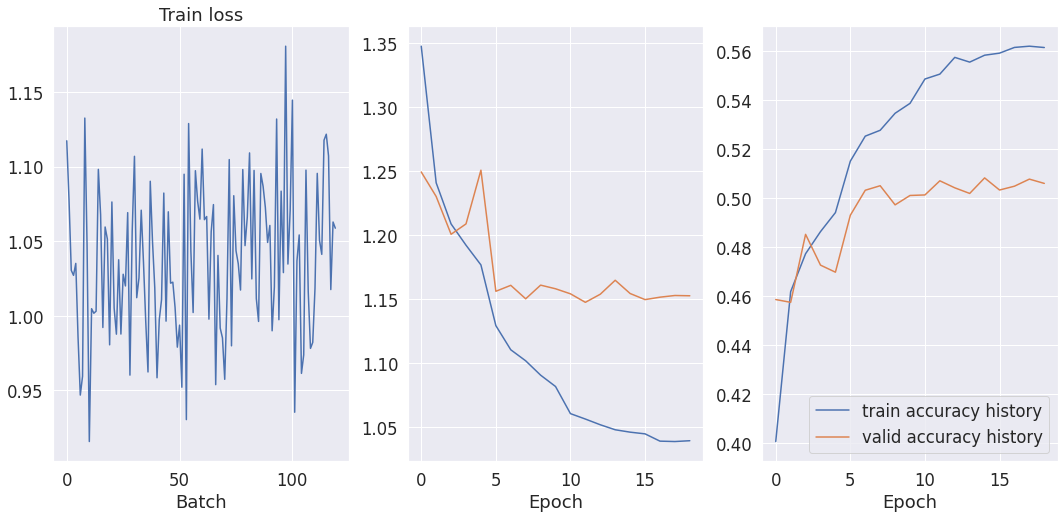

Epoch: 20 | Time: 0m 9s
	Train Loss: 1.039
	 Val. Loss: 1.155


In [138]:
train_model(classifier, device, train_loader, val_loader, opt, criterion, lr_scheduler, n_epochs)

## Applying model on the test data

In [139]:
input_ids_test = []
token_type_ids_test = []
attention_masks_test = []

for tweet in test_tweets:

    encoded_dict_test = tokenizer.encode_plus(text=tweet,
                                              add_special_tokens=True,
                                              max_length=128,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              return_tensors='pt')
    
    input_ids_test.append(encoded_dict_test['input_ids'])
    token_type_ids_test.append(encoded_dict_test['token_type_ids'])
    attention_masks_test.append(encoded_dict_test['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
token_type_ids_test = torch.cat(token_type_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

In [140]:
BATCH_SIZE = 64
test_dataset = TensorDataset(input_ids_test, token_type_ids_test, attention_masks_test, test_labels)

test_dataloader = DataLoader(test_dataset,
                             sampler=RandomSampler(test_dataset),
                             batch_size=BATCH_SIZE)

In [141]:
len(test_dataset)

3798

In [142]:
%%time
model.eval()
test_sentence_embeddings = []
test_sentence_labels = []

for i, batch in enumerate(test_dataloader):
    batch_input_ids = batch[0].to(device)
    batch_token_type_ids = batch[1].to(device)
    batch_attention_mask = batch[2].to(device)
    batch_labels = batch[3].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, 
                        token_type_ids=batch_token_type_ids,
                        attention_mask=batch_attention_mask)
        hidden_states = outputs[2]
        pooled_output = torch.cat(tuple([hidden_states[i] for i in [-4, -3, -2, -1]]), dim=-1)
        batch_attention_mask = batch_attention_mask.unsqueeze(-1).expand(pooled_output.shape)
        pooled_output = torch.mul(pooled_output, batch_attention_mask)
        pooled_output = torch.sum(pooled_output, dim=1) / torch.sum(batch_attention_mask, dim=1)

    test_sentence_embeddings.append(pooled_output)
    test_sentence_labels.append(batch_labels)

test_sentence_embeddings = torch.cat(test_sentence_embeddings, dim=0)
test_sentence_labels = torch.cat(test_sentence_labels, dim=0)

CPU times: user 14.9 s, sys: 11.4 s, total: 26.3 s
Wall time: 26.3 s


In [143]:
BATCH_SIZE = 256
test_dataset = TensorDataset(test_sentence_embeddings, test_sentence_labels)
test_loader = DataLoader(test_dataset, 
                         sampler=RandomSampler(test_dataset),
                         batch_size=BATCH_SIZE)

In [144]:
test_loss, test_accuracy = evaluate(classifier, device, test_loader, criterion)

In [145]:
print('Accuracy on test data: {}'.format(test_accuracy))

Accuracy on test data: 0.5093141555786133


## TF-IDF features

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [147]:
def print_results(estimator, estimator_type, X_val, y_val):
    print('F1 score for {} on validation data: {}'.format(estimator_type, f1_score(estimator.predict(X_val), y_val, average='weighted')))
    print('Accuracy score for {} on validation data: {}'.format(estimator_type, accuracy_score(estimator.predict(X_val), y_val)))

In [148]:
X_train, X_val, y_train, y_val = train_test_split(train_tweets, train_labels, train_size=0.8)

In [149]:
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=30000)

word_vectorizer.fit(X_train)
train_features = word_vectorizer.transform(X_train)

val_features = word_vectorizer.transform(X_val)

In [150]:
log_reg = LogisticRegression(C=10, max_iter=1000)
log_reg.fit(train_features, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [151]:
print_results(log_reg, 'log reg', val_features, y_val)

F1 score for log reg on validation data: 0.5755029843213909
Accuracy score for log reg on validation data: 0.5761661807580175


## Conclusions

It would be more useful to fine-tune BERT on this task than just extract embeddings and combine them to get tweet embeddings. I suppose that the scores would be much higher in this case because the text from tweets is quite specific.